In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['axes.linewidth'] = 2 #set the value globally
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
import simpleaudio as sa

# time
import time

# save and load
import pickle

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.inspection import permutation_importance

In [2]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt2 = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')


### drop all NaN kinematic and chemistry values
apogee_nofilt = apogee_nofilt2.dropna(subset=['FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR'])
apogee_nofilt = apogee_nofilt.reset_index(drop=True)
GC_db = pd.read_csv('data/GCs_20RHMRT.csv', delimiter=',')

In [3]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

GC_stars_dict = {}

param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36,
                 'RV': RV_index,
                 'PMRA': PMRA_index,
                 'PMDEC': PMDEC_index}


ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [4]:
### reading dim reduction w/ kin results

with open('saved_runs_5_RT/GC_stars_dict_kin.pkl', 'rb') as f:
    GC_stars_dict = pickle.load(f)

In [5]:
RHMRT_stars_count = [] # list of # of control stars
field_stars_count = [] # list of # of total stars

### going through the clusters and counting how many RHMRT and field stars each one has
for key in GC_stars_dict:
    if GC_stars_dict[key][8] is None:
        RHMRT_stars_count.append(0)
        field_stars_count.append(0)
    else:
        RHMRT_stars_count.append(len(GC_stars_dict[key][8]))
        field_stars_count.append(len(GC_stars_dict[key][0]))

### now we go through and only keep the GCs that had 20 or more RHMRT stars
### otherwise we discard the cluster as it doesn't satisfy the set minimum of spatial candidate member stars
new_RHMRT_stars_count = [] # RHMRT star counts of clusters that meet the study requirements
new_field_stars_count = [] # field star counts of clusters that meet the study requirements
selected_cluster_indices = [] # indices of the clusters that met the requirement
selected_cluster_names = [] # names of the clusters that met the requirement
notable_clusters = [] # list of notable cluster names that had 10-19 RHMRT stars that might still work with the method


for i in range(len(RHMRT_stars_count)):
    # if the number of the RHMRT stars was greater than 20, we keep the cluster in the study. Otherwise we remove it
    if RHMRT_stars_count[i] >= 20: 
        new_RHMRT_stars_count.append(RHMRT_stars_count[i])
        new_field_stars_count.append(field_stars_count[i])
        selected_cluster_indices.append(i)
        selected_cluster_names.append(GC_name_list[i])
    elif RHMRT_stars_count[i] >= 10 and RHMRT_stars_count[i] < 20:
        notable_clusters.append(GC_name_list[i])


# tsne x,y coords
tsne_control_X = np.empty(len(selected_cluster_indices), dtype=np.ndarray)
tsne_control_Y = np.empty(len(selected_cluster_indices), dtype=np.ndarray)
tsne_all_X = np.empty(len(selected_cluster_indices), dtype=np.ndarray)
tsne_all_Y = np.empty(len(selected_cluster_indices), dtype=np.ndarray)

# umap x,y coords
umap_control_X = np.empty(len(selected_cluster_indices), dtype=np.ndarray)
umap_control_Y = np.empty(len(selected_cluster_indices), dtype=np.ndarray)
umap_all_X = np.empty(len(selected_cluster_indices), dtype=np.ndarray)
umap_all_Y = np.empty(len(selected_cluster_indices), dtype=np.ndarray)

#  RHMRT star indices
RHMRT_indices = np.empty(len(selected_cluster_indices), dtype=np.ndarray)

# going through the GCs chosen in the study and splitting up the tsne and umap data into arrays
for ind, name in enumerate(selected_cluster_names):
    tsne_control_X[ind] = GC_stars_dict[name][2]
    tsne_control_Y[ind] = GC_stars_dict[name][3]
    tsne_all_X[ind] = GC_stars_dict[name][0]
    tsne_all_Y[ind] = GC_stars_dict[name][1]
    
    umap_control_X[ind] = GC_stars_dict[name][6]
    umap_control_Y[ind] = GC_stars_dict[name][7]
    umap_all_X[ind] = GC_stars_dict[name][4]
    umap_all_Y[ind] = GC_stars_dict[name][5]
    
    RHMRT_indices[ind] = GC_stars_dict[name][8]

In [6]:
### reading dbscan for ctrls

with open('saved_runs_5_RT/tsne_ctrl_inds.pkl', 'rb') as f:
    tsne_ctrl_inds = pickle.load(f)
    
with open('saved_runs_5_RT/umap_ctrl_inds.pkl', 'rb') as f:
    umap_ctrl_inds = pickle.load(f)

In [7]:
GC_stars_dict_nokin = {}

param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR', 'ASPCAPFLAG', 'STARFLAG',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 15 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                  'FE_H_err': abundance_index + 1,
                  'C_FE': abundance_index + 2,
                  'C_FE_err': abundance_index + 3,
                  'CI_FE': abundance_index + 4,
                  'CI_FE_err': abundance_index + 5,
                  'N_FE': abundance_index + 6,
                  'N_FE_err': abundance_index + 7,
                  'O_FE': abundance_index + 8,
                  'O_FE_err': abundance_index + 9,
                  'MG_FE': abundance_index + 10,
                  'MG_FE_err': abundance_index + 11,
                  'AL_FE': abundance_index + 12,
                  'AL_FE_err': abundance_index + 13,
                  'SI_FE': abundance_index + 14,
                  'SI_FE_err': abundance_index + 15,
                  'P_FE': abundance_index + 16,
                  'P_FE_err': abundance_index + 17,
                  'S_FE': abundance_index + 18,
                  'S_FE_err': abundance_index + 19,
                  'K_FE': abundance_index + 20,
                  'K_FE_err': abundance_index + 21,
                  'CA_FE': abundance_index + 22,
                  'CA_FE_err': abundance_index + 23,
                  'TI_FE': abundance_index + 24,
                  'TI_FE_err': abundance_index + 25,
                  'TIII_FE': abundance_index + 26,
                  'TIII_FE_err': abundance_index + 27,
                  'V_FE': abundance_index + 28,
                  'V_FE_err': abundance_index + 29,
                  'CR_FE': abundance_index + 30,
                  'CR_FE_err': abundance_index + 31,
                  'MN_FE': abundance_index + 32,
                  'MN_FE_err': abundance_index + 33,
                  'CO_FE': abundance_index + 34,
                  'CO_FE_err': abundance_index + 35,
                  'NI_FE': abundance_index + 36,
                  'NI_FE_err': abundance_index + 37,
                  'RV': RV_index, 'RV_err': RV_index + 1,
                  'PMRA': PMRA_index, 'PMRA_err': PMRA_index + 1,
                  'PMDEC': PMDEC_index, 'PMDEC_err': PMDEC_index + 1,
                 'APOGEE_ID': 0, 'GAIA_ID': 1, 'RA': 4, 'DEC': 5}

ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [8]:
### reading dim reduction w/ kin results

with open('saved_runs_5_RT/GC_stars_dict_nokin.pkl', 'rb') as f:
    GC_stars_dict_nokin = pickle.load(f)

In [9]:
control_stars_count_nokin = [] # confirmed cluster member stars
field_stars_count_nokin = [] # total cluster field stars

### going through the cluster dictionary and counting how many control and field stars for each cluster
### this step was included to filter out any GCs that did not have identified cluster member stars (control stars)
for key in GC_stars_dict_nokin:
    if GC_stars_dict_nokin[key][8] is None or GC_stars_dict_nokin[key][9] is None:
        control_stars_count_nokin.append(0)
        field_stars_count_nokin.append(0)
    else:
        control_stars_count_nokin.append(len(GC_stars_dict_nokin[key][2]))
        field_stars_count_nokin.append(len(GC_stars_dict_nokin[key][0]))
        
### saving the field and control count of the clusters that had successful control star identification
final_control_stars_count_nokin = []
final_field_stars_count_nokin = []
### saving the names and indices of the clusters that had successful control star identification
final_cluster_indices_nokin = []
final_cluster_names_nokin = []
discarded_clusters = [] # clusters that found no control stars, might be worth looking into to

for ind, count in enumerate(control_stars_count_nokin):
    if count != 0:
        final_control_stars_count_nokin.append(control_stars_count_nokin[ind])
        final_field_stars_count_nokin.append(field_stars_count_nokin[ind])
        final_cluster_indices_nokin.append(ind)
        final_cluster_names_nokin.append(selected_cluster_names[ind])
    else:
        discarded_clusters.append(selected_cluster_names[ind])


### picking out the tsne and umap coords for the final clusters of the study
tsne_control_X_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)
tsne_control_Y_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)
tsne_all_X_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)
tsne_all_Y_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)

umap_control_X_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)
umap_control_Y_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)
umap_all_X_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)
umap_all_Y_nokin = np.empty(len(final_cluster_names_nokin), dtype=np.ndarray)



for ind, name in enumerate(final_cluster_names_nokin):
    tsne_control_X_nokin[ind] = GC_stars_dict_nokin[name][2]
    tsne_control_Y_nokin[ind] = GC_stars_dict_nokin[name][3]
    tsne_all_X_nokin[ind] = GC_stars_dict_nokin[name][0]
    tsne_all_Y_nokin[ind] = GC_stars_dict_nokin[name][1]
    
    umap_control_X_nokin[ind] = GC_stars_dict_nokin[name][6]
    umap_control_Y_nokin[ind] = GC_stars_dict_nokin[name][7]
    umap_all_X_nokin[ind] = GC_stars_dict_nokin[name][4]
    umap_all_Y_nokin[ind] = GC_stars_dict_nokin[name][5]

In [10]:
with open('saved_runs_5_RT/final_et_stars.pkl', 'rb') as f:
    final_et_both = pickle.load(f)
    
with open('saved_runs_5_RT/final_tsne_et_stars.pkl', 'rb') as f:
    final_et_tsne = pickle.load(f)
    
with open('saved_runs_5_RT/final_umap_et_stars.pkl', 'rb') as f:
    final_et_umap = pickle.load(f)
    
with open('saved_runs_5_RT/tsne_group_inds.pkl', 'rb') as f:
    tsne_group_inds = pickle.load(f)
    
with open('saved_runs_5_RT/umap_group_inds.pkl', 'rb') as f:
    umap_group_inds = pickle.load(f)

### grabbing all stars of each cluster

In [29]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, df, name, rhm_deg, rt_deg):
    
    fov_new = 5 * rt_deg
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov_new and i <= ra + fov_new and df['DEC'].values[count] >= dec - fov_new and df['DEC'].values[count] <= dec + fov_new:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a ' + str(fov_new) + 'x' + str(fov_new) + ' fov of the GC')
    
    return stars

In [30]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict

In [31]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

In [32]:
def master_load(ra, dec, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]

In [33]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

In [34]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

In [35]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    return data_snrfilter

In [36]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 15)
    M3_SNR_filter = SNR_filter(M3_abundance_filter)
    
    #print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

In [37]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg, name):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trhmrt2: {:.2f}\trt: {:.2f}'.format(rhm_deg, (rhm_deg + rt_deg) / 2, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    ### TEST: rhm stars
    in_halfmass2 = in_circle(ra, dec, rhm_deg, ra_filtered, dec_filtered)  
    indices_control2 = np.where(in_halfmass2==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within rhm".format(len(indices_control2[0])) + " and {} stars within (rhm+rt)/2".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    # checking for any control stars within rhm
    if len(indices_control[0]) >= 20:
        # create a folder with name of GC only if there are stars in the rhm
        try: 
            os.makedirs('GCs_20RHMRT_N_ctrl_sigma_cluster/' + name)
        except OSError as error:
            print('Directory ' + name + ' already exists')
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm', zorder=2)
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt', zorder=2)
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt', zorder=2)
    
    fov = 5
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_filtered, dec_filtered, 'ok', linestyle='none', markersize=1, label='Stars', zorder=0.5)
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre', zorder=0.7)
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title('Filtered RA DEC for ' + name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    if len(indices_control[0]) >= 20:
        plt.savefig('GCs_20RHMRT_N_ctrl_sigma_cluster/'+name+'/radec.png')
    plt.close('all')
    
    
    # no control stars within rt
    if len(indices_control[0]) < 20:
        print('Less than 20 control stars within (rhm+rt)/2')
        return [None]
    
    else:
        return indices_control

In [38]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pre_nonerr_array = []
    params_arr = []
    
    pre_err_array = []
    
    #print(data_filter)
    
    for key in param_dict:
        if 'err' not in str(key):
            pre_nonerr_array.append(data_filter[param_dict[key]])
            params_arr.append(key)
        else:
            pre_err_array.append(data_filter[param_dict[key]])
    
    pre_nonerr_array = np.array(pre_nonerr_array)
    pre_err_array = np.array(pre_err_array)
    
    standardized = []
    standardized_err = []
    
    for i in pre_nonerr_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized.append(i)
        
    for i in pre_err_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized_err.append(i)
        
    return [standardized, standardized_err]

In [39]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [40]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

In [41]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pre_nonerr_array = []
    params_arr = []
    
    pre_err_array = []
    
    for key in param_dict:
        if 'err' not in str(key):
            pre_nonerr_array.append(data_filter[param_dict[key]])
            params_arr.append(key)
        else:
            pre_err_array.append(data_filter[param_dict[key]])
    
    pre_nonerr_array = np.array(pre_nonerr_array)
    pre_err_array = np.array(pre_err_array)
    
    standardized = []
    standardized_err = []
    
    for i in pre_nonerr_array:
        #mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized.append(i)
        
    for i in pre_err_array:
        #mean, sigma = np.nanmean(i), np.nanstd(i)
        #norm = (i - mean) / sigma
        standardized_err.append(i)
        
    return [standardized, standardized_err]

In [42]:
def find_and_filter_stars(GC_name, master_param_dict, db, dataset, params):
    print('\nProcessing:', GC_name)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    standardized_array, standardized_err_array = standardize_data(GC_filter_data, master_param_dict)
    #print(len(standardized_array[0]))
    #print(len(standardized_err_array))
    
    return [standardized_array, standardized_err_array]

In [43]:
GC_stars = {}
GC_stars_err = {}
GC_stars_Fe = {}
GC_stars_Fe_err = {}

In [45]:
for count, i in tqdm(enumerate(GC_name_list)):
    GC_stars[i] = find_and_filter_stars(i, all_param_dict, GC_db, apogee_nofilt, param_list)[0]
    GC_stars_err[i] = find_and_filter_stars(i, all_param_dict, GC_db, apogee_nofilt, param_list)[1]


Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC

Processing: NGC_104
977 stars in a 8.034513185785698x8.034513185785698 fov of the GC

Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC

Processing: NGC_288
193 stars in a 3.022734119166619x3.022734119166619 fov of the GC

Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC

Processing: NGC_362
743 stars in a 2.983425483786819x2.983425483786819 fov of the GC

Processing: NGC_1851
239 stars in a 3.0466301676533436x3.0466301676533436 fov of the GC

Processing: NGC_1851
239 stars in a 3.0466301676533436x3.0466301676533436 fov of the GC

Processing: NGC_1904
246 stars in a 1.438514973206377x1.438514973206377 fov of the GC

Processing: NGC_1904
246 stars in a 1.438514973206377x1.438514973206377 fov of the GC

Processing: NGC_2808
499 stars in a 4.724195371102934x4.724195371102934 fov of the GC

Processing: NGC_2808
499 stars in a 4.724195

In [112]:
with open('random_forests/GC_stars.pkl', 'wb') as f:
    pickle.dump(GC_stars, f)

### GC_stars[cluster] goes 19 abundances, 3 kinematics, GAIA ID, APOGEE ID, RA, DEC

In [46]:
both_ctrl_inds = []
for n, i in enumerate(tsne_ctrl_inds):
    temp = []
    for j in i:
        if j in umap_ctrl_inds[n]:
            temp.append(j)
    both_ctrl_inds.append(temp)

In [101]:
GC_stars_classification_field_ctrl = {}
GC_stars_classification_field_et = {}

for n, i in enumerate(GC_stars):
    temp_field_ctrl = np.empty(len(GC_stars[i][0]), dtype=int) # creating array with the number of field stars of cluster using empty placeholders
    temp_field_et = np.empty(len(GC_stars[i][0]), dtype=int)
    
    for j in range(len(GC_stars[i][0])):
        if j in both_ctrl_inds[n]:
            temp_field_ctrl[j] = 1
        else:
            temp_field_ctrl[j] = 0
        
        if j in final_et_both[n]:
            temp_field_et[j] = 2
        elif j in both_ctrl_inds[n]:
            temp_field_et[j] = 1
        else:
            temp_field_et[j] = 0
    
    GC_stars_classification_field_ctrl[i] = temp_field_ctrl
    GC_stars_classification_field_et[i] = temp_field_et

In [102]:
GC_stars_dict_field_ctrl = {}
GC_stars_dict_field_et = {}

params_field_ctrl = ['FE_H', 'C_FE',  'CI_FE', 'N_FE',
            'O_FE', 'MG_FE', 'AL_FE', 'SI_FE',
            'P_FE', 'S_FE', 'K_FE', 'CA_FE',
            'TI_FE','TIII_FE', 'V_FE', 'CR_FE',
            'MN_FE','CO_FE','NI_FE', 
          'PMRA', 'PMDEC', 'RV']

params_field_et = ['FE_H', 'C_FE',  'CI_FE', 'N_FE',
            'O_FE', 'MG_FE', 'AL_FE', 'SI_FE',
            'P_FE', 'S_FE', 'K_FE', 'CA_FE',
            'TI_FE','TIII_FE', 'V_FE', 'CR_FE',
            'MN_FE','CO_FE','NI_FE']

for key in GC_stars:
    cluster_dict_field_ctrl = {}
    cluster_dict_field_et = {}
    
    for n, i in enumerate(GC_stars[key]):
        if n < len(params_field_ctrl):
            cluster_dict_field_ctrl[params_field_ctrl[n]] = i
        
        if n < len(params_field_et):
            cluster_dict_field_et[params_field_et[n]] = i
            
    cluster_dict_field_ctrl['CLASS'] = GC_stars_classification_field_ctrl[key]
    cluster_dict_field_et['CLASS'] = GC_stars_classification_field_et[key]
    
    GC_stars_dict_field_ctrl[key] = pd.DataFrame.from_dict(cluster_dict_field_ctrl)
    GC_stars_dict_field_et[key] = pd.DataFrame.from_dict(cluster_dict_field_et)

In [104]:
bad_GCs_ctrl = ['NGC_6171', 'NGC_6380', 'NGC_6388', 'NGC_6441', 'Ter_9', 'NGC_6522', 'NGC_6544', 'NGC_6553', 'NGC_6715']
bad_GCs_et = ['NGC_362', 'NGC_6171', 'NGC_6380', 'NGC_6388', 'NGC_6441', 'Ter_9', 'NGC_6522', 'NGC_6544', 'NGC_6553', 'NGC_6715'] # the last one is special cuz no ET stars

features_importance_field_ctrl_list = []
features_importance_field_et_list = []
features_importance_field_ctrl_list_perm = []
features_importance_field_et_list_perm = []

for count, name in tqdm(enumerate(GC_name_list)):
    print('Processing: ' + name + '\t' + str(count + 1) + ' of ' + str(len(GC_name_list)))
    
    if name not in bad_GCs_ctrl:
        data_field_ctrl = GC_stars_dict_field_ctrl[name]

        X_field_ctrl = data_field_ctrl.drop('CLASS', axis=1)
        Y_field_ctrl = data_field_ctrl['CLASS']

        X_train_field_ctrl, X_test_field_ctrl, Y_train_field_ctrl, Y_test_field_ctrl = train_test_split(X_field_ctrl, Y_field_ctrl, test_size=0.2)

        feature_names_field_ctrl = [i for i in X_field_ctrl]

        forest_field_ctrl = RandomForestClassifier(n_estimators=500)
        forest_field_ctrl.fit(X_train_field_ctrl, Y_train_field_ctrl)

        Y_pred_field_ctrl = forest_field_ctrl.predict(X_test_field_ctrl)
        accuracy_field_ctrl = accuracy_score(Y_test_field_ctrl, Y_pred_field_ctrl)

        importances_field_ctrl = forest_field_ctrl.feature_importances_
        std_field_ctrl = np.std([tree.feature_importances_ for tree in forest_field_ctrl.estimators_], axis=0)
        forest_importances_field_ctrl = pd.Series(importances_field_ctrl, index=feature_names_field_ctrl)
        features_importance_field_ctrl_list.append([importances_field_ctrl, std_field_ctrl])

        result_field_ctrl = permutation_importance(forest_field_ctrl, X_test_field_ctrl, Y_test_field_ctrl, n_repeats=10, random_state=42, n_jobs=2)
        forest_importances_field_ctrl_perm = pd.Series(result_field_ctrl.importances_mean, index=feature_names_field_ctrl)
        features_importance_field_ctrl_list_perm.append([result_field_ctrl.importances_mean, result_field_ctrl.importances_std])
    
    
    
    if name not in bad_GCs_et:
        data_field_et = GC_stars_dict_field_et[name]

        X_field_et = data_field_et.drop('CLASS', axis=1)
        Y_field_et = data_field_et['CLASS']

        X_train_field_et, X_test_field_et, Y_train_field_et, Y_test_field_et = train_test_split(X_field_et, Y_field_et, test_size=0.2)

        feature_names_field_et = [i for i in X_field_et]

        forest_field_et = RandomForestClassifier(n_estimators=500)
        forest_field_et.fit(X_train_field_et, Y_train_field_et)

        Y_pred_field_et = forest_field_et.predict(X_test_field_et)
        accuracy_field_et = accuracy_score(Y_test_field_et, Y_pred_field_et)

        importances_field_et = forest_field_et.feature_importances_
        std_field_et = np.std([tree.feature_importances_ for tree in forest_field_et.estimators_], axis=0)
        forest_importances_field_et = pd.Series(importances_field_et, index=feature_names_field_et)
        features_importance_field_et_list.append([importances_field_et, std_field_et])

        result_field_et = permutation_importance(forest_field_et, X_test_field_et, Y_test_field_et, n_repeats=10, random_state=42, n_jobs=2)
        forest_importances_field_et_perm = pd.Series(result_field_et.importances_mean, index=feature_names_field_et)
        features_importance_field_et_list_perm.append([result_field_et.importances_mean, result_field_et.importances_std])
    
    '''try:
        os.makedirs('random_forests/' + name)
    except OSError as error:
        print('\nDirectory ' + name + ' already exists')'''

    '''fig, ax = plt.subplots(2, 1, figsize=(10,8))
    forest_importances_field_ctrl.plot.bar(yerr=std_field_ctrl, ax=ax[0])
    ax[0].set_title("Feature importances using MDI for field vs ctrl\nAccuracy: " + str(round(accuracy_field_ctrl, 2)))
    ax[0].set_ylabel("Mean decrease in impurity")
    
    forest_importances_field_et.plot.bar(yerr=std_field_et, ax=ax[1])
    ax[1].set_title("Feature importances using MDI for field vs et\nAccuracy: " + str(round(accuracy_field_et, 2)))
    ax[1].set_ylabel("Mean decrease in impurity")
    
    plt.tight_layout()
    plt.savefig('random_forests/' + name + '/MDI.png', facecolor='white', transparent=False)'''
    
    
    
    '''fig, ax = plt.subplots(2, 1, figsize=(10,8))
    forest_importances_field_ctrl_perm.plot.bar(yerr=result_field_ctrl.importances_std, ax=ax[0])
    ax[0].set_title("Feature importances using Permutations for field vs ctrl\nAccuracy: " + str(round(accuracy_field_ctrl, 2)))
    ax[0].set_ylabel("Mean accuracy decrease")
    
    forest_importances_field_et_perm.plot.bar(yerr=result_field_et.importances_std, ax=ax[1])
    ax[1].set_title("Feature importances using Permutations for field vs et\nAccuracy: " + str(round(accuracy_field_et, 2)))
    ax[1].set_ylabel("Mean accuracy decrease")
    
    plt.tight_layout()
    plt.savefig('random_forests/' + name + '/Perm.png', facecolor='white', transparent=False)'''
    
    #plt.close('all')

Processing: NGC_104	1 of 34
Processing: NGC_288	2 of 34
Processing: NGC_362	3 of 34
Processing: NGC_1851	4 of 34
Processing: NGC_1904	5 of 34
Processing: NGC_2808	6 of 34
Processing: NGC_3201	7 of 34
Processing: NGC_4590	8 of 34
Processing: NGC_5024	9 of 34
Processing: NGC_5139	10 of 34
Processing: NGC_5272	11 of 34
Processing: NGC_5904	12 of 34
Processing: NGC_6121	13 of 34
Processing: NGC_6171	14 of 34
Processing: NGC_6205	15 of 34
Processing: NGC_6218	16 of 34
Processing: NGC_6254	17 of 34
Processing: NGC_6273	18 of 34
Processing: NGC_6341	19 of 34
Processing: NGC_6380	20 of 34
Processing: NGC_6388	21 of 34
Processing: NGC_6397	22 of 34
Processing: NGC_6441	23 of 34
Processing: Ter_9	24 of 34
Processing: NGC_6522	25 of 34
Processing: NGC_6544	26 of 34
Processing: NGC_6553	27 of 34
Processing: NGC_6656	28 of 34
Processing: NGC_6715	29 of 34
Processing: NGC_6752	30 of 34
Processing: NGC_6809	31 of 34
Processing: NGC_6838	32 of 34
Processing: NGC_7078	33 of 34
Processing: NGC_7089	34 o

In [105]:
'''with open('random_forests/features_importance_field_ctrl_list_good_GCs.pkl', 'wb') as f:
    pickle.dump(features_importance_field_ctrl_list, f)
    
with open('random_forests/features_importance_field_et_list_good_GCs.pkl', 'wb') as f:
    pickle.dump(features_importance_field_et_list, f)
    
with open('random_forests/features_importance_field_ctrl_list_perm_good_GCs.pkl', 'wb') as f:
    pickle.dump(features_importance_field_ctrl_list_perm, f)
    
with open('random_forests/features_importance_field_et_list_perm_good_GCs.pkl', 'wb') as f:
    pickle.dump(features_importance_field_et_list_perm, f)'''

In [28]:
with open('random_forests/features_importance_field_ctrl_list_good_GCs.pkl', 'rb') as f:
    features_importance_field_ctrl_list = pickle.load(f)
    
with open('random_forests/features_importance_field_et_list_good_GCs.pkl', 'rb') as f:
    features_importance_field_et_list = pickle.load(f)

with open('random_forests/features_importance_field_ctrl_list_perm_good_GCs.pkl', 'rb') as f:
    features_importance_field_ctrl_list_perm = pickle.load(f)
    
with open('random_forests/features_importance_field_et_list_perm_good_GCs.pkl', 'rb') as f:
    features_importance_field_et_list_perm = pickle.load(f)

## top 3 abundances

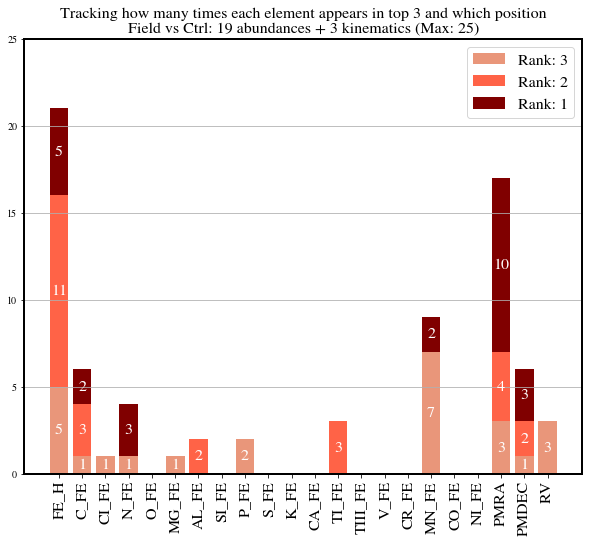

In [110]:
### only looking at top 3 abundances
### tracking the number of appearances in top 5 and which place for each abundance
### field vs ctrl

ranked_features_list = []

for n, i in enumerate(features_importance_field_ctrl_list):
    ranked_feature_MDI, ranked_feature_names = (list(t) for t in zip(*sorted(zip(i[0], feature_names_field_ctrl))))
    
    ranked_features_list.append([ranked_feature_MDI,ranked_feature_names])
    
ranked_features_apperances = {}

for key in feature_names_field_ctrl:
    ranked_features_apperances[key] = [0,0,0]
    
for c, (n, i) in enumerate(ranked_features_list):
    ranked_dict = {}
    for j in range(len(i)):
        if i[j] == i[-3]:
            ranked_dict[i[j]] = [1,0,0]
        elif i[j] == i[-2]:
            ranked_dict[i[j]] = [0,1,0]
        elif i[j] == i[-1]:
            ranked_dict[i[j]] = [0,0,1]
    
    for key in ranked_dict:
        first = 0
        second = 0
        third = 0
        for count, rank in enumerate(ranked_dict[key]):
            if rank == 1:
                if count == 0:
                    third = 1
                elif count == 1:
                    second = 1
                elif count == 2:
                    first = 1
                    
        if first == 1:
            ranked_features_apperances[key][2] += 1
        elif second == 1:
            ranked_features_apperances[key][1] += 1
        elif third == 1:
            ranked_features_apperances[key][0] += 1
            
fig, ax = plt.subplots(figsize=(10,8))
bottoms = [0,0,0]
colors = ['darksalmon', 'tomato', 'maroon']
for n, i in enumerate(ranked_features_apperances['FE_H']):
    ax.bar('FE_H', i, bottom = bottoms[n-1], color=colors[n], label='Rank: ' + str(3-n))
    bottoms[n] = bottoms[n-1] + i

for key in ranked_features_apperances:
    bottoms = [0,0,0]
    for n, i in enumerate(ranked_features_apperances[key]):
        bars = ax.bar(key, i, bottom = bottoms[n-1], color=colors[n])
        bottoms[n] = bottoms[n-1] + i
        
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                plt.annotate(height, xy=(bar.get_x() + bar.get_width()/2, bottoms[n-1] + height/2), ha='center', va='center', fontsize=16, color='white')
    



plt.title('Tracking how many times each element appears in top 3 and which position\nField vs Ctrl: 19 abundances + 3 kinematics (Max: 25)', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.grid(axis = 'y')
plt.ylim(0,25)
plt.legend(fontsize=16)
plt.savefig('random_forests/field_ctrl_MDI_top3_good_GCs.png', facecolor='white', transparent=False)
plt.show()

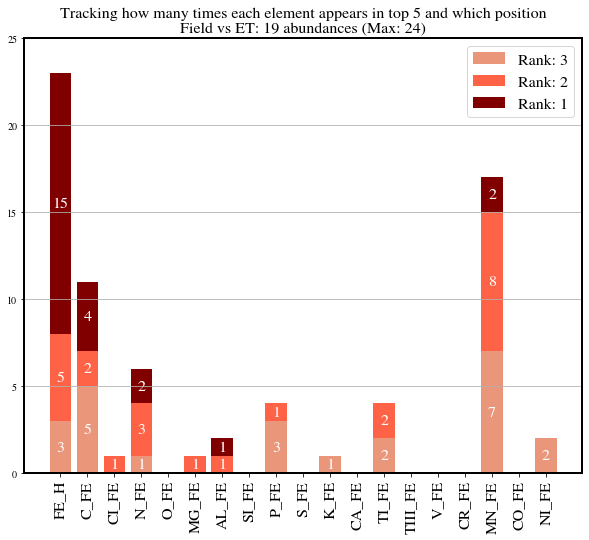

In [111]:
### only looking at top 3 abundances
### tracking the number of appearances in top 5 and which place for each abundance
### field vs et

ranked_features_list = []

for n, i in enumerate(features_importance_field_et_list):
    ranked_feature_MDI, ranked_feature_names = (list(t) for t in zip(*sorted(zip(i[0], feature_names_field_et))))
    
    ranked_features_list.append([ranked_feature_MDI,ranked_feature_names])
    
ranked_features_apperances = {}

for key in feature_names_field_et:
    ranked_features_apperances[key] = [0,0,0]
    
for c, (n, i) in enumerate(ranked_features_list):
    ranked_dict = {}
    for j in range(len(i)):
        if i[j] == i[-3]:
            ranked_dict[i[j]] = [1,0,0]
        elif i[j] == i[-2]:
            ranked_dict[i[j]] = [0,1,0]
        elif i[j] == i[-1]:
            ranked_dict[i[j]] = [0,0,1]
    
    for key in ranked_dict:
        first = 0
        second = 0
        third = 0
        for count, rank in enumerate(ranked_dict[key]):
            if rank == 1:
                if count == 0:
                    third = 1
                elif count == 1:
                    second = 1
                elif count == 2:
                    first = 1
                    
        if first == 1:
            ranked_features_apperances[key][2] += 1
        elif second == 1:
            ranked_features_apperances[key][1] += 1
        elif third == 1:
            ranked_features_apperances[key][0] += 1
            
fig, ax = plt.subplots(figsize=(10,8))
bottoms = [0,0,0]
colors = ['darksalmon', 'tomato', 'maroon']
for n, i in enumerate(ranked_features_apperances['FE_H']):
    ax.bar('FE_H', i, bottom = bottoms[n-1], color=colors[n], label='Rank: ' + str(3-n))
    bottoms[n] = bottoms[n-1] + i

for key in ranked_features_apperances:
    bottoms = [0,0,0]
    for n, i in enumerate(ranked_features_apperances[key]):
        bars = ax.bar(key, i, bottom = bottoms[n-1], color=colors[n])
        bottoms[n] = bottoms[n-1] + i
        
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                plt.annotate(height, xy=(bar.get_x() + bar.get_width()/2, bottoms[n-1] + height/2), ha='center', va='center', fontsize=16, color='white')


plt.title('Tracking how many times each element appears in top 5 and which position\nField vs ET: 19 abundances (Max: 24)', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.ylim(0,25)
plt.grid(axis = 'y')
plt.legend(fontsize=16)
plt.savefig('random_forests/field_et_MDI_top3_good_GCs.png', facecolor='white', transparent=False)
plt.show()

## top 5 abundances

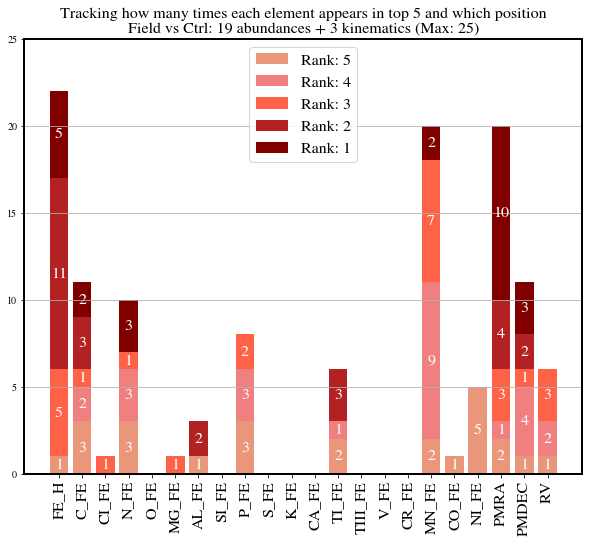

In [106]:
### only looking at top 5 abundances
### tracking the number of appearances in top 5 and which place for each abundance
### field vs ctrl

ranked_features_list = []

for n, i in enumerate(features_importance_field_ctrl_list):
    ranked_feature_MDI, ranked_feature_names = (list(t) for t in zip(*sorted(zip(i[0], feature_names_field_ctrl))))
    
    ranked_features_list.append([ranked_feature_MDI,ranked_feature_names])
    
ranked_features_apperances = {}

for key in feature_names_field_ctrl:
    ranked_features_apperances[key] = [0,0,0,0,0]
    
for c, (n, i) in enumerate(ranked_features_list):
    ranked_dict = {}
    for j in range(len(i)):
        if i[j] == i[-5]:
            ranked_dict[i[j]] = [1,0,0,0,0]
        elif i[j] == i[-4]:
            ranked_dict[i[j]] = [0,1,0,0,0]
        elif i[j] == i[-3]:
            ranked_dict[i[j]] = [0,0,1,0,0]
        elif i[j] == i[-2]:
            ranked_dict[i[j]] = [0,0,0,1,0]
        elif i[j] == i[-1]:
            ranked_dict[i[j]] = [0,0,0,0,1]
    
    for key in ranked_dict:
        first = 0
        second = 0
        third = 0
        fourth = 0
        fifth = 0
        for count, rank in enumerate(ranked_dict[key]):
            if rank == 1:
                if count == 0:
                    fifth = 1
                elif count == 1:
                    fourth = 1
                elif count == 2:
                    third = 1
                elif count == 3:
                    second = 1
                elif count == 4:
                    first = 1
                    
        if first == 1:
            ranked_features_apperances[key][4] += 1
        elif second == 1:
            ranked_features_apperances[key][3] += 1
        elif third == 1:
            ranked_features_apperances[key][2] += 1
        elif fourth == 1:
            ranked_features_apperances[key][1] += 1
        elif fifth == 1:
            ranked_features_apperances[key][0] += 1
            
fig, ax = plt.subplots(figsize=(10,8))
bottoms = [0,0,0,0,0]
colors = ['darksalmon', 'lightcoral', 'tomato', 'firebrick', 'maroon']
for n, i in enumerate(ranked_features_apperances['FE_H']):
    ax.bar('FE_H', i, bottom = bottoms[n-1], color=colors[n], label='Rank: ' + str(5-n))
    bottoms[n] = bottoms[n-1] + i

for key in ranked_features_apperances:
    bottoms = [0,0,0,0,0]
    for n, i in enumerate(ranked_features_apperances[key]):
        bars = ax.bar(key, i, bottom = bottoms[n-1], color=colors[n])
        bottoms[n] = bottoms[n-1] + i
        
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                plt.annotate(height, xy=(bar.get_x() + bar.get_width()/2, bottoms[n-1] + height/2), ha='center', va='center', fontsize=16, color='white')
    



plt.title('Tracking how many times each element appears in top 5 and which position\nField vs Ctrl: 19 abundances + 3 kinematics (Max: 25)', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.grid(axis = 'y')
plt.ylim(0,25)
plt.legend(fontsize=16)
plt.savefig('random_forests/field_ctrl_MDI_top5_good_GCs.png', facecolor='white', transparent=False)
plt.show()

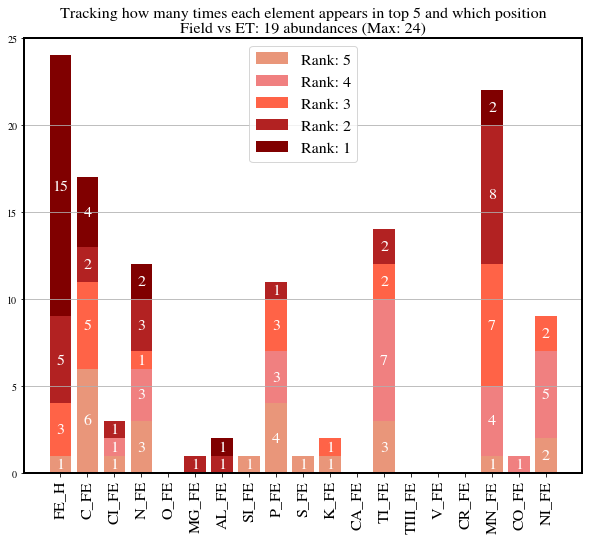

In [107]:
### only looking at top 5 abundances
### tracking the number of appearances in top 5 and which place for each abundance
### field vs et

ranked_features_list = []

for n, i in enumerate(features_importance_field_et_list):
    ranked_feature_MDI, ranked_feature_names = (list(t) for t in zip(*sorted(zip(i[0], feature_names_field_et))))
    
    ranked_features_list.append([ranked_feature_MDI,ranked_feature_names])
    
ranked_features_apperances = {}

for key in feature_names_field_et:
    ranked_features_apperances[key] = [0,0,0,0,0]
    
for c, (n, i) in enumerate(ranked_features_list):
    ranked_dict = {}
    for j in range(len(i)):
        if i[j] == i[-5]:
            ranked_dict[i[j]] = [1,0,0,0,0]
        elif i[j] == i[-4]:
            ranked_dict[i[j]] = [0,1,0,0,0]
        elif i[j] == i[-3]:
            ranked_dict[i[j]] = [0,0,1,0,0]
        elif i[j] == i[-2]:
            ranked_dict[i[j]] = [0,0,0,1,0]
        elif i[j] == i[-1]:
            ranked_dict[i[j]] = [0,0,0,0,1]
    
    for key in ranked_dict:
        first = 0
        second = 0
        third = 0
        fourth = 0
        fifth = 0
        for count, rank in enumerate(ranked_dict[key]):
            if rank == 1:
                if count == 0:
                    fifth = 1
                elif count == 1:
                    fourth = 1
                elif count == 2:
                    third = 1
                elif count == 3:
                    second = 1
                elif count == 4:
                    first = 1
                    
        if first == 1:
            ranked_features_apperances[key][4] += 1
        elif second == 1:
            ranked_features_apperances[key][3] += 1
        elif third == 1:
            ranked_features_apperances[key][2] += 1
        elif fourth == 1:
            ranked_features_apperances[key][1] += 1
        elif fifth == 1:
            ranked_features_apperances[key][0] += 1
            
fig, ax = plt.subplots(figsize=(10,8))
bottoms = [0,0,0,0,0]
colors = ['darksalmon', 'lightcoral', 'tomato', 'firebrick', 'maroon']
for n, i in enumerate(ranked_features_apperances['FE_H']):
    ax.bar('FE_H', i, bottom = bottoms[n-1], color=colors[n], label='Rank: ' + str(5-n))
    bottoms[n] = bottoms[n-1] + i

for key in ranked_features_apperances:
    bottoms = [0,0,0,0,0]
    for n, i in enumerate(ranked_features_apperances[key]):
        bars = ax.bar(key, i, bottom = bottoms[n-1], color=colors[n])
        bottoms[n] = bottoms[n-1] + i
        
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                plt.annotate(height, xy=(bar.get_x() + bar.get_width()/2, bottoms[n-1] + height/2), ha='center', va='center', fontsize=16, color='white')


plt.title('Tracking how many times each element appears in top 5 and which position\nField vs ET: 19 abundances (Max: 24)', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.ylim(0,25)
plt.grid(axis = 'y')
plt.legend(fontsize=16)
plt.savefig('random_forests/field_et_MDI_top5_good_GCs.png', facecolor='white', transparent=False)
plt.show()

## cumulative abundance score

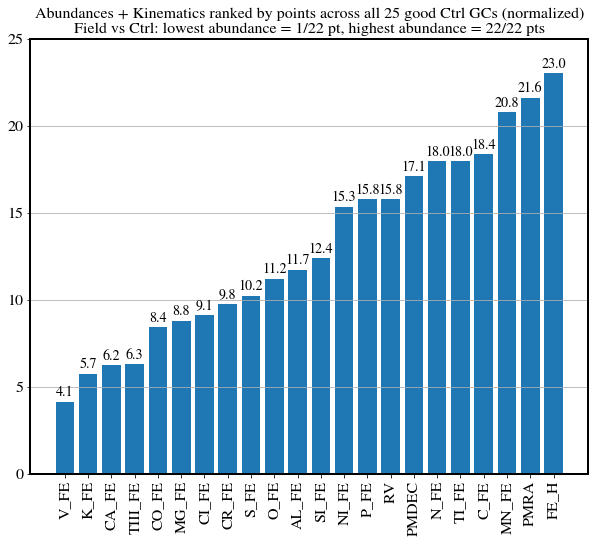

In [108]:
### assigning a score to each abundance based on how they rank out of 22
### lowest rank = 1/22, highest rank = 22/22
### sum up the scores across all GCs

ranked_features_list = []

for n, i in enumerate(features_importance_field_ctrl_list):
    ranked_feature_MDI, ranked_feature_names = (list(t) for t in zip(*sorted(zip(i[0], feature_names_field_ctrl))))
    
    ranked_features_list.append([ranked_feature_MDI,ranked_feature_names])
    
ranked_features_scoring = {}

for key in feature_names_field_ctrl:
    ranked_features_scoring[key] = 0

    
for c, (n, i) in enumerate(ranked_features_list):
    score_dict = {}
    score = 1 / 22
    for j in i:
        score_dict[j] = score
        score += 1 / 22
    
    for key in score_dict:
        ranked_features_scoring[key] = ranked_features_scoring[key] + score_dict[key]

for key in ranked_features_scoring:
    ranked_features_scoring[key] = ranked_features_scoring[key]

sorted_ranked_features_scoring = sorted(ranked_features_scoring.items(), key=lambda x:x[1])

sorted_ranked_features_scoring = dict(sorted_ranked_features_scoring)

fig = plt.figure(figsize=(10,8))
bars = plt.bar(sorted_ranked_features_scoring.keys(), sorted_ranked_features_scoring.values())
for bar in bars:
    height = bar.get_height()
    plt.annotate(round(height,1), xy=(bar.get_x() + bar.get_width()/2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=14)
    
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,25)
plt.grid(axis='y')
plt.title('Abundances + Kinematics ranked by points across all 25 good Ctrl GCs (normalized)\nField vs Ctrl: lowest abundance = 1/22 pt, highest abundance = 22/22 pts', fontsize=16)
plt.savefig('random_forests/field_ctrl_MDI_cumulative_good_GCs.png', facecolor='white', transparent=False)
plt.show()

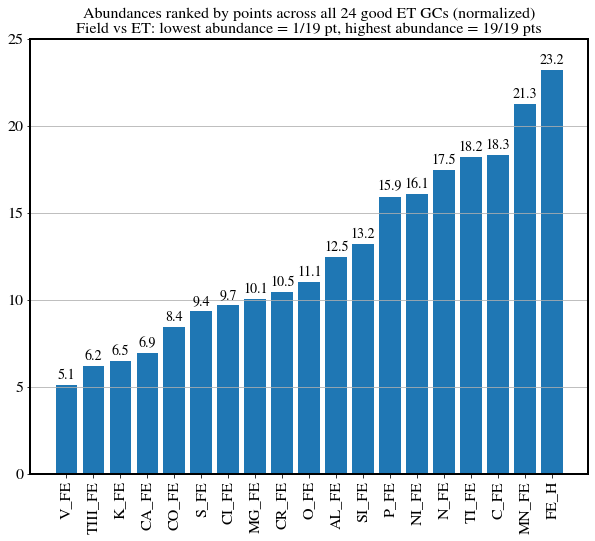

In [109]:
### assigning a score to each abundance based on how they rank out of 22
### lowest rank = 1/19, highest rank = 19/19
### sum up the scores across all GCs

ranked_features_list = []

for n, i in enumerate(features_importance_field_et_list):
    ranked_feature_MDI, ranked_feature_names = (list(t) for t in zip(*sorted(zip(i[0], feature_names_field_et))))
    
    ranked_features_list.append([ranked_feature_MDI,ranked_feature_names])
    
ranked_features_scoring = {}

for key in feature_names_field_et:
    ranked_features_scoring[key] = 0

    
for c, (n, i) in enumerate(ranked_features_list):
    score_dict = {}
    score = 1 / 19
    for j in i:
        score_dict[j] = score
        score += 1 / 19
    
    for key in score_dict:
        ranked_features_scoring[key] = ranked_features_scoring[key] + score_dict[key]

for key in ranked_features_scoring:
    ranked_features_scoring[key] = ranked_features_scoring[key]

sorted_ranked_features_scoring = sorted(ranked_features_scoring.items(), key=lambda x:x[1])

sorted_ranked_features_scoring = dict(sorted_ranked_features_scoring)

fig = plt.figure(figsize=(10,8))
bars = plt.bar(sorted_ranked_features_scoring.keys(), sorted_ranked_features_scoring.values())
for bar in bars:
    height = bar.get_height()
    plt.annotate(round(height,1), xy=(bar.get_x() + bar.get_width()/2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=14)
    
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,25)
plt.grid(axis='y')
plt.title('Abundances ranked by points across all 24 good ET GCs (normalized)\nField vs ET: lowest abundance = 1/19 pt, highest abundance = 19/19 pts', fontsize=16)
plt.savefig('random_forests/field_et_MDI_cumulative_good_GCs.png', facecolor='white', transparent=False)
plt.show()